In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

In [2]:
# setting default fontsizes for plots

s=16 # CHANGE FONTSIZE HERE

plt.rc('font', size=s) #controls default text size
plt.rc('axes', titlesize=s) #fontsize of the title
plt.rc('axes', labelsize=s) #fontsize of the x and y labels
plt.rc('xtick', labelsize=s) #fontsize of the x tick labels
plt.rc('ytick', labelsize=s) #fontsize of the y tick labels
plt.rc('legend', fontsize=s) #fontsize of the legend
#import matplotlib as mpl
#mpl.rcParams['font.weight']= 'normal'


In [3]:
# setting color palettes for figures
#red_rgb = [103,0,31] # edges of RdBu
#blue_rgb = [5,48,97] # edges of RdBu
red_rgb =[188,61,62] # from Emily
blue_rgb = [54,122,177] # from Emily
red_rgb = np.array(red_rgb)/255
blue_rgb = np.array(blue_rgb)/255
alpha = .2 # transparency inside boxplots, for datapts etc.
colors = [red_rgb,blue_rgb]
# Set your custom color palette
myPalette = sns.set_palette(sns.color_palette(colors))


In [4]:
vid_names_hcp = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical", "Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]
# video names used in the HCP dataset

## Load and preprocess online data

In [5]:
# Load
final_data_folder = r'/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/RT_online_task'
dat_all = pd.read_csv(os.path.join(final_data_folder,'RT_data_all_subs.csv'))
dat_all.head()

,Unnamed: 0,sub_ind,respDur_keys,respDur_rt,respAfter_keys,respAfter_rt,movie,date,movie_ind,consistency
0,0,86.0,left,3.070585,left,0.868510,COAXINGB0,2021-07-25_08h39.36.916,0.0,1.0
1,1,86.0,right,1.909830,right,0.669700,BILLIARDA1,2021-07-25_08h39.36.916,1.0,1.0
2,2,86.0,right,2.362310,right,0.497975,DRIFTINGA2,2021-07-25_08h39.36.916,2.0,1.0
3,3,86.0,left,4.312300,left,1.568915,FISHING3,2021-07-25_08h39.36.916,3.0,1.0
4,4,86.0,right,1.539055,right,0.667690,RANDOMMECH4,2021-07-25_08h39.36.916,4.0,1.0


In [7]:
# preprocess step 1: remove inconsistent during-after responses
print('before:',dat_all.shape)
print(dat_all.groupby(['movie']).count().sub_ind)
dat_all = dat_all.loc[dat_all['consistency']==1,:] # select only consistent responses (i.e., same response during and after)
print('after:',dat_all.shape)
dat_all.groupby(['movie']).count().sub_ind

before: (887, 10)
movie
BILLIARDA1      94
COAXINGB0       93
DRIFTINGA2      94
FISHING3        89
RANDOMMECH4     77
SCARING5        78
SEDUCINGB6      99
STARA7          89
SURPRISINGB8    94
TENNISA9        80
Name: sub_ind, dtype: int64
after: (887, 10)


movie
BILLIARDA1      94
COAXINGB0       93
DRIFTINGA2      94
FISHING3        89
RANDOMMECH4     77
SCARING5        78
SEDUCINGB6      99
STARA7          89
SURPRISINGB8    94
TENNISA9        80
Name: sub_ind, dtype: int64

In [8]:
# preprocess step 2: remove subjects with less than 8 responses (to make sure movie-wise figures are comparable more or less)
thresh = 8
trial_counts = dat_all.groupby("sub_ind").count()["movie_ind"]
bad_subs = trial_counts[(trial_counts < thresh)].index
#print(bad_subs)
dat_all = dat_all.set_index('sub_ind') # make subj_idx the index
dat_all.drop(bad_subs, inplace=True) # remove bad subjects
dat_all = dat_all.reset_index() #bring back subj_idx as a column

print("Nr. of subjects left",len(dat_all.groupby("sub_ind")))
print("Nr. of rows:",dat_all.shape)

Nr. of subjects left 90
Nr. of rows: (821, 10)


In [9]:
# rename "left" and "right" with "social" and "non-social"
dat_all['respDur_keys'] = dat_all['respDur_keys'].map({'left': 'Social', 'right': 'Non-social'})
dat_all['respAfter_keys'] = dat_all['respAfter_keys'].map({'left': 'Social', 'right': 'Non-social', 'down': 'Unsure'})

In [10]:
# for LME: add logRTduring and after columns
dat_all['logRT_dur'] = np.log(dat_all['respDur_rt'])
dat_all['logRT_after'] = np.log(dat_all['respAfter_rt'])
dat_all

,sub_ind,Unnamed: 0,respDur_keys,respDur_rt,respAfter_keys,respAfter_rt,movie,date,movie_ind,consistency,logRT_dur,logRT_after
0,86.0,0,Social,3.070585,Social,0.868510,COAXINGB0,2021-07-25_08h39.36.916,0.0,1.0,1.121868,-0.140976
1,86.0,1,Non-social,1.909830,Non-social,0.669700,BILLIARDA1,2021-07-25_08h39.36.916,1.0,1.0,0.647014,-0.400925
2,86.0,2,Non-social,2.362310,Non-social,0.497975,DRIFTINGA2,2021-07-25_08h39.36.916,2.0,1.0,0.859640,-0.697205
3,86.0,3,Social,4.312300,Social,1.568915,FISHING3,2021-07-25_08h39.36.916,3.0,1.0,1.461471,0.450384
4,86.0,4,Non-social,1.539055,Non-social,0.667690,RANDOMMECH4,2021-07-25_08h39.36.916,4.0,1.0,0.431169,-0.403931
...,...,...,...,...,...,...,...,...,...,...,...,...
816,69.0,1003,Social,4.639200,Social,0.601600,FISHING3,2021-07-25_14h45.48.361,3.0,1.0,1.534542,-0.508163
817,69.0,1004,Non-social,3.087600,Non-social,0.311200,RANDOMMECH4,2021-07-25_14h45.48.361,4.0,1.0,1.127394,-1.167319
818,69.0,1006,Social,2.388300,Social,0.425800,SEDUCINGB6,2021-07-25_14h45.48.361,6.0,1.0,0.870582,-0.853786
819,69.0,1007,Non-social,2.380100,Non-social,0.421600,STARA7,2021-07-25_14h45.48.361,7.0,1.0,0.867143,-0.863698


## Run LMEs

In [11]:
from pymer4.models import Lmer

## LME during

In [260]:
# LME during without movie

model = Lmer('logRT_dur ~  respDur_keys +(respDur_keys|sub_ind)', data=dat_all) # ff: mean response, rf:subjID
print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
#plt.hist(model.residuals,color='grey')
stats.normaltest(model.residuals)

Formula: logRT_dur~respDur_keys+(respDur_keys|sub_ind)

Family: gaussian	 Inference: parametric

Number of observations: 821	 Groups: {'sub_ind': 90.0}

Log-likelihood: -626.944 	 AIC: 1253.888

Random effects:

                        Name    Var    Std
sub_ind          (Intercept)  0.200  0.448
sub_ind   respDur_keysSocial  0.020  0.141
Residual                      0.214  0.462

                 IV1                 IV2   Corr
sub_ind  (Intercept)  respDur_keysSocial -0.927

Fixed effects:

                    Estimate  2.5_ci  97.5_ci     SE      DF  T-stat  P-val  \
(Intercept)            1.520   1.417    1.623  0.053  86.753  28.848    0.0   
respDur_keysSocial     0.202   0.132    0.273  0.036  88.916   5.619    0.0   

                    Sig  
(Intercept)         ***  
respDur_keysSocial  ***  


NormaltestResult(statistic=0.19399171401223042, pvalue=0.907559766140045)

In [261]:
# LME during with movie

model = Lmer('logRT_dur ~  respDur_keys +(respDur_keys|sub_ind) + (1|movie)', data=dat_all) # ff: mean response, rf:subjID
print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
#plt.hist(model.residuals,color='grey')
stats.normaltest(model.residuals)

Formula: logRT_dur~respDur_keys+(respDur_keys|sub_ind)+(1|movie)

Family: gaussian	 Inference: parametric

Number of observations: 821	 Groups: {'sub_ind': 90.0, 'movie': 10.0}

Log-likelihood: -505.221 	 AIC: 1010.443

Random effects:

                        Name    Var    Std
sub_ind          (Intercept)  0.212  0.460
sub_ind   respDur_keysSocial  0.057  0.239
movie            (Intercept)  0.085  0.292
Residual                      0.139  0.373

                 IV1                 IV2   Corr
sub_ind  (Intercept)  respDur_keysSocial -0.713

Fixed effects:

                    Estimate  2.5_ci  97.5_ci     SE       DF  T-stat  P-val  \
(Intercept)            1.401   1.175    1.628  0.116   16.754  12.124    0.0   
respDur_keysSocial     0.457   0.267    0.647  0.097  149.580   4.717    0.0   

                    Sig  
(Intercept)         ***  
respDur_keysSocial  ***  


NormaltestResult(statistic=4.6637102717503165, pvalue=0.09711541757819701)

- with movie as RFX is a better model (lower AIC)

## LME after

In [263]:
model = Lmer('logRT_after ~  respAfter_keys +(respAfter_keys|sub_ind)', data=dat_all) # ff: mean response, rf:subjID
print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
#plt.hist(model.residuals,color='grey')
stats.normaltest(model.residuals)

Formula: logRT_after~respAfter_keys+(respAfter_keys|sub_ind)

Family: gaussian	 Inference: parametric

Number of observations: 821	 Groups: {'sub_ind': 90.0}

Log-likelihood: -530.342 	 AIC: 1060.683

Random effects:

                          Name    Var    Std
sub_ind            (Intercept)  0.125  0.354
sub_ind   respAfter_keysSocial  0.026  0.160
Residual                        0.168  0.410

                 IV1                   IV2   Corr
sub_ind  (Intercept)  respAfter_keysSocial -0.592

Fixed effects:

                      Estimate  2.5_ci  97.5_ci     SE     DF  T-stat  P-val  \
(Intercept)             -0.282  -0.366   -0.199  0.043  86.56  -6.612  0.000   
respAfter_keysSocial     0.045  -0.021    0.110  0.034  86.43   1.328  0.188   

                      Sig  
(Intercept)           ***  
respAfter_keysSocial       


NormaltestResult(statistic=5.105674724151817, pvalue=0.07786043404921417)

In [296]:
model = Lmer('logRT_after ~  respAfter_keys +(respAfter_keys|sub_ind)+(1|movie)', data=dat_all) # ff: mean response, rf:subjID
print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
#plt.hist(model.residuals,color='grey)
stats.normaltest(model.residuals)

Formula: logRT_after~respAfter_keys+(respAfter_keys|sub_ind)+(1|movie)

Family: gaussian	 Inference: parametric

Number of observations: 821	 Groups: {'sub_ind': 90.0, 'movie': 10.0}

Log-likelihood: -513.375 	 AIC: 1026.750

Random effects:

                          Name    Var    Std
sub_ind            (Intercept)  0.129  0.360
sub_ind   respAfter_keysSocial  0.031  0.176
movie              (Intercept)  0.012  0.109
Residual                        0.155  0.394

                 IV1                   IV2   Corr
sub_ind  (Intercept)  respAfter_keysSocial -0.586

Fixed effects:

                      Estimate  2.5_ci  97.5_ci     SE      DF  T-stat  P-val  \
(Intercept)             -0.278  -0.400   -0.155  0.062  27.170  -4.450  0.000   
respAfter_keysSocial     0.044  -0.086    0.174  0.066  21.825   0.668  0.511   

                      Sig  
(Intercept)           ***  
respAfter_keysSocial       


NormaltestResult(statistic=6.849370281088511, pvalue=0.0325595310515804)

- model improves slightly with movie as RFX but overall no significant effect of response in both "after" models

## Plotting movies


In [12]:
def sort_movies(movies_list):
    if type(movies_list) != 'list':
        movies_list = list(movies_list)

    # sort movies' order to the presentation order
    vid_names_hcp = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical", "Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]
    
    movies_order = np.zeros((10,))
    ind=0
    for ind in range(10):
        movies_order[ind] = [i for i in range(10) if str.upper(vid_names_hcp[i][:4])==str.upper(movies_list[ind][:4])][0]
    print(movies_order)
    movies_order = np.array(movies_order).flatten()
    movies_order = np.array([int(i) for i in movies_order])
    print(movies_order)
    movies_list = [movies_list[i] for i in movies_order]
    return movies_order,movies_list

- so let's start by looking at what's going on in the during and after phases. Does nonsocial really look faster than social in the "during" phase (pooled across movies)? Indiv moviewise data in Analyses-1.ipynb

In [13]:
soc = dat_all.loc[dat_all['respDur_keys']=='Social','respDur_rt']
nonsoc = dat_all.loc[dat_all['respDur_keys']=='Non-social','respDur_rt']
print(f'During: 1. Social: Median={soc.median():.2f}sec (SEM={soc.sem():.2f})) \n\t2. Non-social: Median={nonsoc.median():.2f}sec (SEM={nonsoc.median():.2f}).')

soc = dat_all.loc[dat_all['respAfter_keys']=='Social','respAfter_rt']
nonsoc = dat_all.loc[dat_all['respAfter_keys']=='Non-social','respAfter_rt']
print(f'After:  1. Social: Median={soc.median():.2f}sec (SEM={soc.sem():.2f}sec)\n\t2. Non-social: Median={nonsoc.median():.2f}sec (SEM={nonsoc.median():.2f}).')

During: 1. Social: Median=5.78sec (SEM=0.19)) 
	2. Non-social: Median=4.43sec (SEM=4.43).
After:  1. Social: Median=0.76sec (SEM=0.02sec)
	2. Non-social: Median=0.76sec (SEM=0.76).


Text(0.5, 1.0, 'Pooled\nacross movies \n(after movie)')

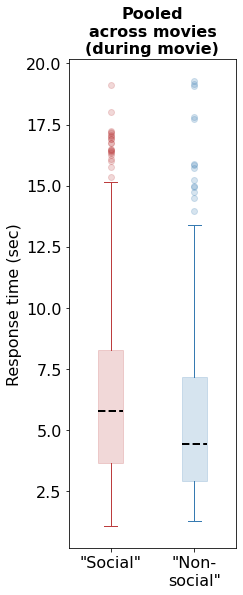

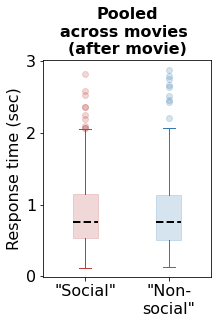

In [19]:
fig, ax = plt.subplots(figsize=(3,9))
#sns.boxplot(x='respDur_keys',y='respDur_rt',data=dat_all, palette=myPalette)
#plt.legend([],[], frameon=False)
bp1 = box_plot(dat_all.loc[dat_all['respDur_keys']=='Social','respDur_rt'], red_rgb, red_rgb,0,True)
bp2 = box_plot(dat_all.loc[dat_all['respDur_keys']=='Non-social','respDur_rt'], blue_rgb, blue_rgb,1,True)
plt.xticks(range(2),['"Social"','"Non-\nsocial"'])
plt.ylabel('Response time (sec)')
plt.title('Pooled\nacross movies\n(during movie)',fontweight='bold')

fig, ax = plt.subplots(figsize=(3,4))
#sns.boxplot(x='respAfter_keys',y='respAfter_rt',data=dat_all, palette=myPalette)
#plt.legend([],[], frameon=False)
bp1 = box_plot(dat_all.loc[dat_all['respAfter_keys']=='Social','respAfter_rt'], red_rgb, red_rgb,0,True)
bp2 = box_plot(dat_all.loc[dat_all['respAfter_keys']=='Non-social','respAfter_rt'], blue_rgb, blue_rgb,1,True)
plt.xticks(range(2),['"Social"','"Non-\nsocial"'])
plt.ylabel('Response time (sec)')
plt.title('Pooled\nacross movies \n(after movie)',fontweight='bold')



In [416]:
all_movies_RTtask = np.unique(dat_all['movie'])
_,all_movies_RTtask = sort_movies(all_movies_RTtask) # get movienames from the RT task
print(all_movies_RTtask)

pop_responses = np.array([1,0,0,1,0,1,1,0,1,0]) # popular responses
soc_movies = [all_movies_RTtask[i] for i in range(10) if pop_responses[i]==1 ]
soc_movies

[1. 0. 2. 3. 4. 5. 6. 7. 8. 9.]
[1 0 2 3 4 5 6 7 8 9]
['COAXINGB0', 'BILLIARDA1', 'DRIFTINGA2', 'FISHING3', 'RANDOMMECH4', 'SCARING5', 'SEDUCINGB6', 'STARA7', 'SURPRISINGB8', 'TENNISA9']


['COAXINGB0', 'FISHING3', 'SCARING5', 'SEDUCINGB6', 'SURPRISINGB8']

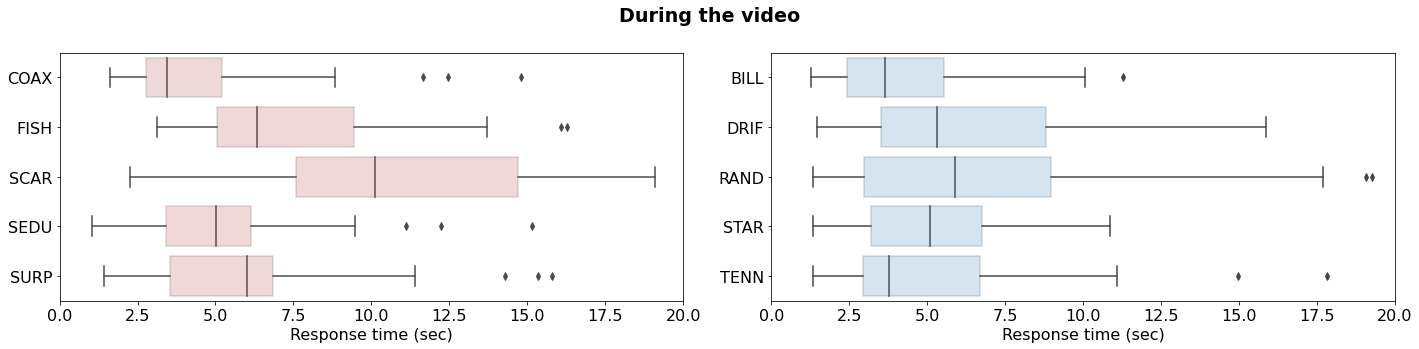

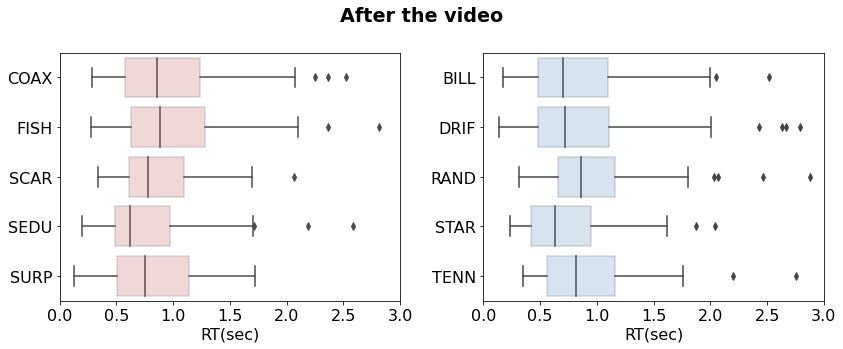

In [342]:
# plot generally social and generally nonsocial movies to get a look at why RTsocial could've come our longer

def edit_yticks(ax):
    lbls=ax.get_yticklabels()
    lbls = [lbls[i].get_text()[:4] for i in range(len(lbls))]
    ax.set_yticklabels(lbls)
    plt.ylabel('')

plt.figure(1,figsize=(20,5))
plt.suptitle('During the video',fontweight='bold')

ax = plt.subplot(121)
dat = dat_all.loc[(dat_all['respDur_keys']=='Social')  & (np.array([i in soc_movies for i in dat_all['movie']])),:]
sns.boxplot(y='movie',x='respDur_rt',data=dat, color = red_rgb, orient='h',boxprops = {'facecolor':red_rgb, "zorder":10, "alpha":.2})
edit_yticks(ax)
plt.legend([],[], frameon=False)
plt.xlim(0,20)
plt.ylabel('')
plt.xlabel('Response time (sec)')

ax =plt.subplot(122)
dat = dat_all.loc[(dat_all['respDur_keys']=='Non-social') & ([i not in soc_movies for i in dat_all['movie']]),:]
sns.boxplot(y='movie',x='respDur_rt',data=dat, color = blue_rgb,orient='h',boxprops = {'facecolor':blue_rgb, "zorder":10, "alpha":.2})
edit_yticks(ax)
plt.legend([],[], frameon=False)
plt.xlim(0,20)
plt.xlabel('Response time (sec)')
plt.ylabel('')
plt.tight_layout()

plt.figure(2,figsize=(12,5))
plt.suptitle('After the video',fontweight='bold')
ax=plt.subplot(121)
dat = dat_all.loc[(dat_all['respAfter_keys']=='Social')  & (np.array([i in soc_movies for i in dat_all['movie']])),:]
sns.boxplot(y='movie',x='respAfter_rt',data=dat, color = red_rgb, orient='h',boxprops = {'facecolor':red_rgb, "zorder":10, "alpha":.2})
edit_yticks(ax)
plt.legend([],[], frameon=False)
plt.xlim(0,3)
plt.xlabel('RT(sec)')


ax=plt.subplot(122)
dat = dat_all.loc[(dat_all['respAfter_keys']=='Non-social') & ([i not in soc_movies for i in dat_all['movie']]),:]
sns.boxplot(y='movie',x='respAfter_rt',data=dat, color = blue_rgb,orient='h',boxprops = {'facecolor':blue_rgb, "zorder":10, "alpha":.2})
edit_yticks(ax)
plt.legend([],[], frameon=False)
plt.xlim(0,3)
plt.xlabel('RT(sec)')

plt.tight_layout()


In [15]:
def box_plot(data, edge_color, fill_color,pos,v):
    # function to plot custom boxplots
    alpha= .2
    bp = ax.boxplot(data, positions = [pos], patch_artist=True,widths=.3,vert=v,flierprops = dict(markeredgecolor=edge_color,
    markerfacecolor=fill_color, alpha=alpha))
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'caps']:
        plt.setp(bp[element], color=edge_color)
    for element in ['medians']:
        plt.setp(bp[element], color='k',linewidth=2,ls='dashed')

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color,alpha=alpha)#'w'       
        
    return bp

Text(0.5, 1.0, 'Pooled\nacross movies')

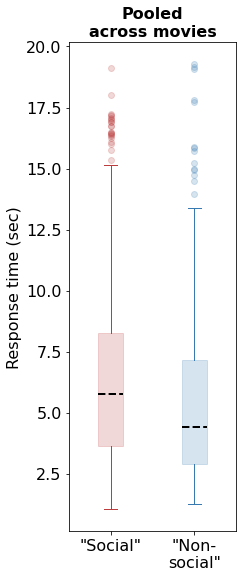

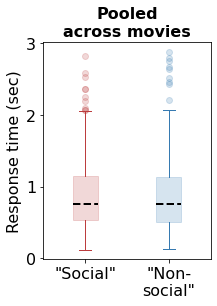

In [344]:
fig, ax = plt.subplots(figsize=(3,9)) # saved figure for paper
#sns.boxplot(x='respDur_keys',y='respDur_rt',data=dat_all, palette=myPalette)
#plt.legend([],[], frameon=False)
bp1 = box_plot(dat_all.loc[dat_all['respDur_keys']=='Social','respDur_rt'], red_rgb, red_rgb,0,True)
bp2 = box_plot(dat_all.loc[dat_all['respDur_keys']=='Non-social','respDur_rt'], blue_rgb, blue_rgb,1,True)
plt.xticks(range(2),['"Social"','"Non-\nsocial"'])
plt.ylabel('Response time (sec)')
plt.title('Pooled\nacross movies',fontweight='bold')

fig, ax = plt.subplots(figsize=(3,4))
#sns.boxplot(x='respAfter_keys',y='respAfter_rt',data=dat_all, palette=myPalette)
#plt.legend([],[], frameon=False)
bp1 = box_plot(dat_all.loc[dat_all['respAfter_keys']=='Social','respAfter_rt'], red_rgb, red_rgb,0,True)
bp2 = box_plot(dat_all.loc[dat_all['respAfter_keys']=='Non-social','respAfter_rt'], blue_rgb, blue_rgb,1,True)
plt.xticks(range(2),['"Social"','"Non-\nsocial"'])
plt.ylabel('Response time (sec)')
plt.title('Pooled\nacross movies',fontweight='bold')






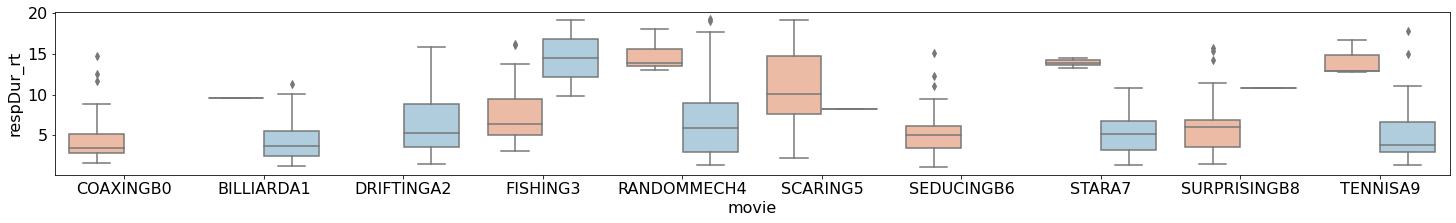

In [345]:
plt.figure(1,figsize=(25,3))
sns.boxplot(x='movie',y='respDur_rt',hue='respDur_keys',data=dat_all, palette='RdBu',hue_order=['Social','Non-social'])
plt.legend([],[], frameon=False)


## Correlate std

In [491]:
hcp_beh_data_folder = r'/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/BehaviorAnalyses/Documented scripts/data/data_for_paper'

data_826 = pd.read_csv(os.path.join(hcp_beh_data_folder,'hcp_social_826subs.csv')) # yes,no,unsure responses for complete subjects
data_826

,index,subj_idx,stim,movie,rt,response,run,accuracy
0,0,168745,Mental,Scaring.AVI,1.252,1,1,1.0
1,1,168745,Mental,SEDUCING-B.AVI,0.578,1,1,1.0
2,2,168745,Random,STAR-A.AVI,1.643,0,1,1.0
3,3,168745,Mental,SURPRISING-B.AVI,1.082,1,1,1.0
4,4,168745,Random,TENNIS-A.AVI,1.232,0,1,1.0
...,...,...,...,...,...,...,...,...
8252,10144,175136,Mental,COAXING-B.AVI,1.542,1,0,1.0
8253,10145,175136,Random,BILLIARD-A.AVI,0.893,0,0,1.0
8254,10146,175136,Random,DRIFTING-A.AVI,0.895,0,0,1.0
8255,10147,175136,Mental,Fishing.AVI,0.985,1,0,1.0


In [492]:
counts_per_movie = data_826.groupby(['movie','response']).count().stim.unstack(level=-1)
counts_per_movie['sum'] = counts_per_movie.sum(axis=1)
counts_per_movie = counts_per_movie.replace(np.nan, 0)
counts_per_movie

response,0,1,9,sum
movie,,,,
BILLIARD-A.AVI,780.0,11.0,34.0,825.0
COAXING-B.AVI,7.0,811.0,6.0,824.0
DRIFTING-A.AVI,782.0,6.0,38.0,826.0
Fishing.AVI,58.0,701.0,67.0,826.0
Random mechanical.AVI,564.0,86.0,176.0,826.0
SEDUCING-B.AVI,5.0,805.0,16.0,826.0
STAR-A.AVI,761.0,20.0,45.0,826.0
SURPRISING-B.AVI,0.0,823.0,3.0,826.0
Scaring.AVI,24.0,783.0,19.0,826.0


In [493]:
counts_per_movie = counts_per_movie.reset_index()# = sort_movies(movies_list)
movies = counts_per_movie['movie'].values
movies_order,_ = sort_movies(movies)
counts_per_movie['movies_order'] = movies_order
counts_per_movie = counts_per_movie.sort_values(by='movies_order')
counts_per_movie = counts_per_movie.set_index('movie')
counts_per_movie

[1. 0. 2. 3. 4. 6. 7. 8. 5. 9.]
[1 0 2 3 4 6 7 8 5 9]


response,0,1,9,sum,movies_order
movie,,,,,
COAXING-B.AVI,7.0,811.0,6.0,824.0,0
BILLIARD-A.AVI,780.0,11.0,34.0,825.0,1
DRIFTING-A.AVI,782.0,6.0,38.0,826.0,2
Fishing.AVI,58.0,701.0,67.0,826.0,3
Random mechanical.AVI,564.0,86.0,176.0,826.0,4
Scaring.AVI,24.0,783.0,19.0,826.0,5
SEDUCING-B.AVI,5.0,805.0,16.0,826.0,6
STAR-A.AVI,761.0,20.0,45.0,826.0,7
SURPRISING-B.AVI,0.0,823.0,3.0,826.0,8


In [494]:
counts_per_movie['yes_pc'] = 100*counts_per_movie[1]/counts_per_movie['sum'] 
counts_per_movie['no_pc'] = 100*counts_per_movie[0]/counts_per_movie['sum'] 
counts_per_movie['unsure_pc'] = 100*counts_per_movie[9]/counts_per_movie['sum'] 
counts_per_movie

response,0,1,9,sum,movies_order,yes_pc,no_pc,unsure_pc
movie,,,,,,,,
COAXING-B.AVI,7.0,811.0,6.0,824.0,0,98.422330,0.849515,0.728155
BILLIARD-A.AVI,780.0,11.0,34.0,825.0,1,1.333333,94.545455,4.121212
DRIFTING-A.AVI,782.0,6.0,38.0,826.0,2,0.726392,94.673123,4.600484
Fishing.AVI,58.0,701.0,67.0,826.0,3,84.866828,7.021792,8.111380
Random mechanical.AVI,564.0,86.0,176.0,826.0,4,10.411622,68.280872,21.307506
Scaring.AVI,24.0,783.0,19.0,826.0,5,94.794189,2.905569,2.300242
SEDUCING-B.AVI,5.0,805.0,16.0,826.0,6,97.457627,0.605327,1.937046
STAR-A.AVI,761.0,20.0,45.0,826.0,7,2.421308,92.130751,5.447942
SURPRISING-B.AVI,0.0,823.0,3.0,826.0,8,99.636804,0.000000,0.363196


In [495]:
counts_per_movie['certainty'] = np.abs(counts_per_movie['yes_pc']-counts_per_movie['no_pc'])
counts_per_movie

response,0,1,9,sum,movies_order,yes_pc,no_pc,unsure_pc,certainty
movie,,,,,,,,,
COAXING-B.AVI,7.0,811.0,6.0,824.0,0,98.422330,0.849515,0.728155,97.572816
BILLIARD-A.AVI,780.0,11.0,34.0,825.0,1,1.333333,94.545455,4.121212,93.212121
DRIFTING-A.AVI,782.0,6.0,38.0,826.0,2,0.726392,94.673123,4.600484,93.946731
Fishing.AVI,58.0,701.0,67.0,826.0,3,84.866828,7.021792,8.111380,77.845036
Random mechanical.AVI,564.0,86.0,176.0,826.0,4,10.411622,68.280872,21.307506,57.869249
Scaring.AVI,24.0,783.0,19.0,826.0,5,94.794189,2.905569,2.300242,91.888620
SEDUCING-B.AVI,5.0,805.0,16.0,826.0,6,97.457627,0.605327,1.937046,96.852300
STAR-A.AVI,761.0,20.0,45.0,826.0,7,2.421308,92.130751,5.447942,89.709443
SURPRISING-B.AVI,0.0,823.0,3.0,826.0,8,99.636804,0.000000,0.363196,99.636804


In [496]:
resp_sem_online = dat_all.groupby(['movie']).std()
resp_sem_online

,sub_ind,Unnamed: 0,respDur_rt,respAfter_rt,movie_ind,consistency,logRT_dur,logRT_after
movie,,,,,,,,
BILLIARDA1,29.515415,295.634181,2.297773,0.495791,0.0,0.0,0.542132,0.568666
COAXINGB0,28.935309,292.658834,2.427839,0.505136,0.0,0.0,0.479971,0.519504
DRIFTINGA2,29.765327,295.613790,3.575604,0.544164,0.0,0.0,0.595255,0.599752
FISHING3,29.217271,301.561753,3.553083,0.503483,0.0,0.0,0.434124,0.484105
RANDOMMECH4,30.873863,304.371386,5.025845,0.495614,0.0,0.0,0.748266,0.478437
SCARING5,30.691163,295.981328,4.672893,0.362642,0.0,0.0,0.548437,0.409337
SEDUCINGB6,29.760300,294.514975,2.380374,0.432201,0.0,0.0,0.486300,0.500115
STARA7,29.644390,296.970045,2.727436,0.393153,0.0,0.0,0.527485,0.518626
SURPRISINGB8,29.022960,299.009745,2.853827,0.370251,0.0,0.0,0.505480,0.490242


In [497]:
resp_sem_online = resp_sem_online.reset_index()# = sort_movies(movies_list)
movies = resp_sem_online['movie'].values
movies_order,_ = sort_movies(movies)
resp_sem_online['movies_order'] = movies_order
resp_sem_online = resp_sem_online.sort_values(by='movies_order')
resp_sem_online = resp_sem_online.set_index('movie')
resp_sem_online


[1. 0. 2. 3. 4. 5. 6. 7. 8. 9.]
[1 0 2 3 4 5 6 7 8 9]


,sub_ind,Unnamed: 0,respDur_rt,respAfter_rt,movie_ind,consistency,logRT_dur,logRT_after,movies_order
movie,,,,,,,,,
COAXINGB0,28.935309,292.658834,2.427839,0.505136,0.0,0.0,0.479971,0.519504,0
BILLIARDA1,29.515415,295.634181,2.297773,0.495791,0.0,0.0,0.542132,0.568666,1
DRIFTINGA2,29.765327,295.613790,3.575604,0.544164,0.0,0.0,0.595255,0.599752,2
FISHING3,29.217271,301.561753,3.553083,0.503483,0.0,0.0,0.434124,0.484105,3
RANDOMMECH4,30.873863,304.371386,5.025845,0.495614,0.0,0.0,0.748266,0.478437,4
SCARING5,30.691163,295.981328,4.672893,0.362642,0.0,0.0,0.548437,0.409337,5
SEDUCINGB6,29.760300,294.514975,2.380374,0.432201,0.0,0.0,0.486300,0.500115,6
STARA7,29.644390,296.970045,2.727436,0.393153,0.0,0.0,0.527485,0.518626,7
SURPRISINGB8,29.022960,299.009745,2.853827,0.370251,0.0,0.0,0.505480,0.490242,8


In [517]:
resp_sem_online['respDur_rt']

movie
COAXINGB0       2.427839
BILLIARDA1      2.297773
DRIFTINGA2      3.575604
FISHING3        3.553083
RANDOMMECH4     5.025845
SCARING5        4.672893
SEDUCINGB6      2.380374
STARA7          2.727436
SURPRISINGB8    2.853827
TENNISA9        3.601248
Name: respDur_rt, dtype: float64

In [577]:
dat_all.groupby(['movie','respDur_keys']).count()

sub_ind  Unnamed: 0  respDur_rt  respAfter_keys  \
movie        respDur_keys                                                    
BILLIARDA1   Non-social         87          87          87              87   
             Social              1           1           1               1   
COAXINGB0    Social             86          86          86              86   
DRIFTINGA2   Non-social         89          89          89              89   
FISHING3     Non-social          2           2           2               2   
             Social             80          80          80              80   
RANDOMMECH4  Non-social         66          66          66              66   
             Social              6           6           6               6   
SCARING5     Non-social          1           1           1               1   
             Social             72          72          72              72   
SEDUCINGB6   Social             89          89          89              89   
STARA7       Non-social         82          82          82              82   
             Social              2           2           2               2   
SURPRISINGB8 Non-social          1           1           1               1   
             Social             83          83          83              83   
TENNISA9     Non-social         71          71          71              71   
             Social              3           3           3               3   

                           respAfter_rt  date  movie_ind  consistency  \
movie        respDur_keys                                               
BILLIARDA1   Non-social              87    87         87           87   
             Social                   1     1          1            1   
COAXINGB0    Social                  86    86         86           86   
DRIFTINGA2   Non-social              89    89         89           89   
FISHING3     Non-social               2     2          2            2   
             Social                  80    80         80           80   
RANDOMMECH4  Non-social              66    66         66           66   
             Social                   6     6          6            6   
SCARING5     Non-social               1     1          1            1   
             Social                  72    72         72           72   
SEDUCINGB6   Social                  89    89         89           89   
STARA7       Non-social              82    82         82           82   
             Social                   2     2          2            2   
SURPRISINGB8 Non-social               1     1          1            1   
             Social                  83    83         83           83   
TENNISA9     Non-social              71    71         71           71   
             Social                   3     3          3            3   

                           logRT_dur  logRT_after  
movie        respDur_keys                          
BILLIARDA1   Non-social           87           87  
             Social                1            1  
COAXINGB0    Social               86           86  
DRIFTINGA2   Non-social           89           89  
FISHING3     Non-social            2            2  
             Social               80           80  
RANDOMMECH4  Non-social           66           66  
             Social                6            6  
SCARING5     Non-social            1            1  
             Social               72           72  
SEDUCINGB6   Social               89           89  
STARA7       Non-social           82           82  
             Social                2            2  
SURPRISINGB8 Non-social            1            1  
             Social               83           83  
TENNISA9     Non-social           71           71  
             Social                3            3

In [580]:
def sort_movies_socialness(movies_list):
    if type(movies_list) != 'list':
        movies_list = list(movies_list)

    # sort movies' order to the presentation order
    #vid_names_hcp = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical", "Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]
    vid_names_hcp = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical", "Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]
    socialness_seq = [1,2,7,9,4,5,3,0,8,6]
    vid_names_socialness = [vid_names_hcp[i] for i in socialness_seq]
    vid_names_socialness
        
    movies_order = np.zeros((10,))
    ind=0
    for ind in range(10):
        movies_order[ind] = [i for i in range(10) if str.upper(vid_names_socialness[i][:4])==str.upper(movies_list[ind][:4])][0]
    print(movies_order)
    movies_order = np.array(movies_order).flatten()
    movies_order = np.array([int(i) for i in movies_order])
    print(movies_order)
    movies_list = [movies_list[i] for i in movies_order]
    return movies_order,movies_list

In [581]:
counts_per_movie = counts_per_movie.reset_index()# = sort_movies(movies_list)
movies = counts_per_movie['movie'].values
movies_order,_ = sort_movies_socialness(movies)
counts_per_movie['movies_order'] = movies_order
counts_per_movie = counts_per_movie.sort_values(by='movies_order')
counts_per_movie = counts_per_movie.set_index('movie')
counts_per_movie

[7. 0. 1. 6. 4. 5. 9. 2. 8. 3.]
[7 0 1 6 4 5 9 2 8 3]


response,index,0,1,9,sum,movies_order,yes_pc,no_pc,unsure_pc,certainty
movie,,,,,,,,,,
BILLIARD-A.AVI,1,780.0,11.0,34.0,825.0,0,1.333333,94.545455,4.121212,93.212121
DRIFTING-A.AVI,2,782.0,6.0,38.0,826.0,1,0.726392,94.673123,4.600484,93.946731
STAR-A.AVI,7,761.0,20.0,45.0,826.0,2,2.421308,92.130751,5.447942,89.709443
TENNIS-A.AVI,9,694.0,35.0,97.0,826.0,3,4.237288,84.019370,11.743341,79.782082
Random mechanical.AVI,4,564.0,86.0,176.0,826.0,4,10.411622,68.280872,21.307506,57.869249
Scaring.AVI,5,24.0,783.0,19.0,826.0,5,94.794189,2.905569,2.300242,91.888620
Fishing.AVI,3,58.0,701.0,67.0,826.0,6,84.866828,7.021792,8.111380,77.845036
COAXING-B.AVI,0,7.0,811.0,6.0,824.0,7,98.422330,0.849515,0.728155,97.572816
SURPRISING-B.AVI,8,0.0,823.0,3.0,826.0,8,99.636804,0.000000,0.363196,99.636804


In [582]:
resp_sem_online = resp_sem_online.reset_index()# = sort_movies(movies_list)
movies = resp_sem_online['movie'].values
movies_order,_ = sort_movies_socialness(movies)
resp_sem_online['movies_order'] = movies_order
resp_sem_online = resp_sem_online.sort_values(by='movies_order')
resp_sem_online = resp_sem_online.set_index('movie')
resp_sem_online


[7. 0. 1. 6. 4. 5. 9. 2. 8. 3.]
[7 0 1 6 4 5 9 2 8 3]


,sub_ind,Unnamed: 0,respDur_rt,respAfter_rt,movie_ind,consistency,logRT_dur,logRT_after,movies_order
movie,,,,,,,,,
BILLIARDA1,29.515415,295.634181,2.297773,0.495791,0.0,0.0,0.542132,0.568666,0
DRIFTINGA2,29.765327,295.613790,3.575604,0.544164,0.0,0.0,0.595255,0.599752,1
STARA7,29.644390,296.970045,2.727436,0.393153,0.0,0.0,0.527485,0.518626,2
TENNISA9,30.541336,293.775107,3.601248,0.457537,0.0,0.0,0.624354,0.469435,3
RANDOMMECH4,30.873863,304.371386,5.025845,0.495614,0.0,0.0,0.748266,0.478437,4
SCARING5,30.691163,295.981328,4.672893,0.362642,0.0,0.0,0.548437,0.409337,5
FISHING3,29.217271,301.561753,3.553083,0.503483,0.0,0.0,0.434124,0.484105,6
COAXINGB0,28.935309,292.658834,2.427839,0.505136,0.0,0.0,0.479971,0.519504,7
SURPRISINGB8,29.022960,299.009745,2.853827,0.370251,0.0,0.0,0.505480,0.490242,8


In [589]:
 sns.set_palette(sns.color_palette('RdBu'))

/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


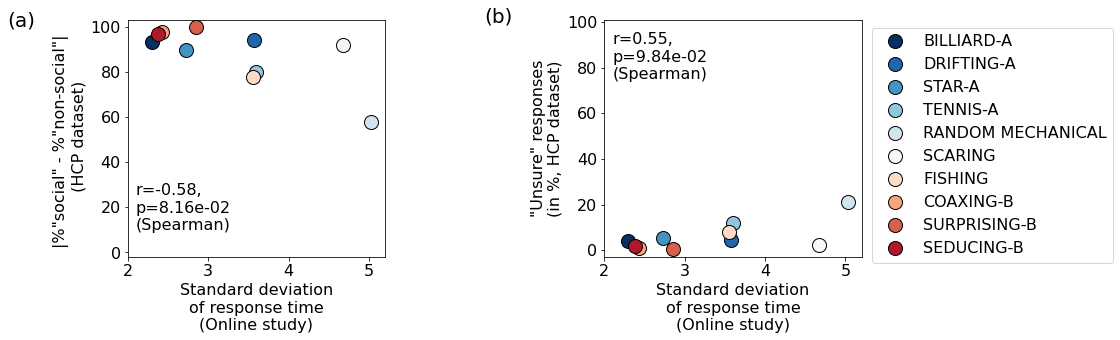

In [663]:
plt.figure(1,figsize=(17,5))
plt.subplot(121)

#plt.plot(resp_sem_online['respDur_rt'],counts_per_movie['certainty'],color='k',marker='o',markersize=10,mec='k',mfc='w',ls='None',label = 'each movie')
plt.subplot(121)
for m in range(10):
    plt.plot(resp_sem_online['respDur_rt'][m],counts_per_movie['certainty'][m],marker='o',markersize=14,mec='k',ls='None',label = str.upper(vid_names_socialness[m]))
plt.ylabel('|%"social" - %"non-social"| \n (HCP dataset)')
plt.xlabel('Standard deviation\nof response time\n(Online study)')
plt.ylim(-2,103)
plt.xlim(2,5.2)
#plt.legend(bbox_to_anchor=[1.01,1])
r,p = stats.spearmanr(resp_sem_online['respDur_rt'],counts_per_movie['certainty'],nan_policy='omit')
plt.text(2.1,10,f'r={r:.2f},\np={p:.2e}\n(Spearman)')
plt.text(.5,100,'(a)',fontsize=20)
plt.subplot(122)
#plt.plot(resp_sem_online['respDur_rt'],counts_per_movie['unsure_pc'],color='k',marker='o',ls='None',markersize =10,mec='k',mfc='w',label = 'each movie')
for m in range(10):
    plt.plot(resp_sem_online['respDur_rt'][m],counts_per_movie['unsure_pc'][m],marker='o',ls='None',mec='k',markersize =14,label = str.upper(vid_names_socialness[m]))

plt.ylabel('"Unsure" responses\n(in %, HCP dataset)')
plt.xlabel('Standard deviation\nof response time\n(Online study)')
plt.ylim(-3,101)
plt.xlim(2,5.2)
plt.legend(bbox_to_anchor=[1.01,1])
r,p = stats.spearmanr(resp_sem_online['respDur_rt'],counts_per_movie['unsure_pc'],nan_policy='omit')
plt.text(2.1,75,f'r={r:.2f},\np={p:.2e}\n(Spearman)')
plt.text(.5,100,'(b)',fontsize=20)


plt.tight_layout()

In [659]:
# exploring colors 
import matplotlib.cm
colors1 = []
for i in range(len(matplotlib.cm.datad["RdBu"])):
    c = matplotlib.cm.datad["RdBu"][i]
    #c = [c[i]*255 for i in range(len(c))]
    colors1.append(c)
#red_rgb = np.array(matplotlib.cm.datad["RdBu"][0])*255
#blue_rgb = np.array(matplotlib.cm.datad["RdBu"][-1])*255
#print('red:',red_rgb,',\n blue:',blue_rgb)


In [662]:
sns.set_palette(sns.color_palette(colors1))